In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

sns.set()

# Load results

To regenerate the benchmarking results from scratch, follow the instructions in README to set up data and submit all benchmarking jobs, and finall aggregate the main results to `aggregated_results/main_results.csv`.

Alternatively, if you do not wish to rerun all experiments, but only want to generate the plots, you can simply run the notebook using the provided results.

In [2]:
df = pd.read_csv("../aggregated_results/main_results.csv").rename(columns={"method": "model"})
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,model,runid
0,DOID:10124,3.471460,2.576823,1.625613,0.870500,0.736712,0.720026,humannet,disgenet,gat,2.0
1,DOID:76,1.573790,1.406519,0.991188,0.742959,0.613922,0.550880,humannet,disgenet,gat,2.0
2,DOID:26,2.777971,2.256059,1.619319,0.836931,0.720772,0.556974,humannet,disgenet,gat,2.0
3,DOID:0060032,2.535641,1.852854,0.481593,0.851550,0.703063,0.595295,humannet,disgenet,gat,2.0
4,DOID:0060158,2.213638,1.805821,1.420786,0.808192,0.785825,0.652411,humannet,disgenet,gat,2.0
...,...,...,...,...,...,...,...,...,...,...,...
42375,DOID:9834,2.698712,1.572180,1.933577,0.881217,0.650081,0.784621,string,disgenet,n2v-svm,2.0
42376,DOID:6419,4.969066,1.105346,0.852374,0.964832,0.549292,0.444653,string,disgenet,n2v-svm,2.0
42377,DOID:8534,2.834508,1.051787,1.940733,0.868061,0.678180,0.703120,string,disgenet,n2v-svm,2.0
42378,DOID:9370,3.912979,0.403573,2.128356,0.899354,0.515204,0.785265,string,disgenet,n2v-svm,2.0


In [3]:
networks = [
    "biogrid",
    "humannet",
    "string",
]
labels = ["disgenet", "gobp"]
models = [
    "adj-logreg",
    "adj-svm",
    "n2v-logreg",
    "n2v-svm",
    "labelprop",
    "gin",
    "gcn",
    "graphsage",
    "gat",
]

network_name_dict = {
    "biogrid": "BioGRID",
    "humannet": "HumanNet",
    "string": "STRING",
}
label_name_dict = {
    "disgenet": "DisGeNET",
    "gobp": "GOBP"
}
model_name_dict = {
    "adj-logreg": "Adj-LogReg",
    "adj-svm": "Adj-SVM",
    "n2v-logreg": "N2V-LogReg",
    "n2v-svm": "N2V-SVM",
    "labelprop": "LabelProp",
    "gin": "GIN",
    "gcn": "GCN",
    "graphsage": "GraphSAGE",
    "gat": "GAT",
}

# Metric to plot
metric = "test_log2pr"

## Compare model performance across datasets

In [4]:
table = (
    df
    .groupby(["label", "network", "model"])
    .mean()[metric]
    .unstack("model")[models]
)

table.index = table.index.map("-".join)
table.index.name = table.columns.name = None
table.style.highlight_max(color="lightgreen", axis=1)

,adj-logreg,adj-svm,n2v-logreg,n2v-svm,labelprop,gin,gcn,graphsage,gat
disgenet-biogrid,0.773919,0.641985,0.743039,0.723508,0.813975,0.646024,0.711310,0.656099,0.606746
disgenet-humannet,1.898492,1.771645,1.651375,1.594197,1.873864,1.620988,1.756402,1.718404,1.865597
disgenet-string,2.603984,2.596474,2.438124,2.310741,2.616390,1.612335,1.846495,1.951016,nan
gobp-biogrid,1.686189,1.463770,1.875727,1.769724,1.248015,1.636782,2.000087,1.928345,1.780118
gobp-humannet,3.412612,3.271601,3.383089,3.230093,3.294126,3.283150,3.437501,3.441251,3.386615
gobp-string,3.481325,3.470232,3.728217,3.593208,3.422871,3.090846,2.931391,3.008488,nan


In [5]:
# Standard deviation across repetitions (each reduced via mean)
(
    df
    .groupby(["label", "network", "model", "runid"])
    .mean()
    .groupby(["label", "network", "model"])
    .std()[metric]
    .unstack("model")[models]
)

model              adj-logreg       adj-svm  n2v-logreg   n2v-svm  labelprop  \
label    network                                                               
disgenet biogrid          0.0  3.812982e-07    0.074014  0.024533        0.0   
         humannet         0.0  8.848850e-07    0.023523  0.029636        0.0   
         string           0.0  3.673797e-07    0.037249  0.067031        0.0   
gobp     biogrid          0.0  5.644923e-06    0.029418  0.035760        0.0   
         humannet         0.0  2.520645e-06    0.030869  0.040305        0.0   
         string           0.0  1.061819e-05    0.019381  0.056145        0.0   

model                   gin       gcn  graphsage       gat  
label    network                                            
disgenet biogrid   0.100029  0.017178   0.052983  0.070652  
         humannet  0.066690  0.053985   0.042076  0.028342  
         string    0.108788  0.075352   0.082668       NaN  
gobp     biogrid   0.054016  0.027715   0.045797  0.042092  
         humannet  0.030017  0.042905   0.037929  0.039679  
         string    0.089705  0.135219   0.207064       NaN

In [6]:
metrics = ["test_log2pr", "test_auroc"]
grouped = df.groupby(["network", "label", "model"])

for network in networks:
    print(network)
    
    for model in models:
        summary = model_name_dict[model]
        
        for label in labels:
            try:
                sub_df = grouped.get_group((network, label, model)).groupby("runid").mean()
            except KeyError:
                continue
                
            for metric in metrics:
                summary += f" & {sub_df[metric].mean():.3f} ± {sub_df[metric].std():.3f}"
        summary += r"\\"
        print(summary)
    print()

biogrid
Adj-LogReg & 0.774 ± 0.000 & 0.544 ± 0.000 & 1.686 ± 0.000 & 0.621 ± 0.000\\
Adj-SVM & 0.642 ± 0.000 & 0.535 ± 0.000 & 1.464 ± 0.000 & 0.595 ± 0.000\\
N2V-LogReg & 0.743 ± 0.074 & 0.558 ± 0.008 & 1.876 ± 0.029 & 0.648 ± 0.002\\
N2V-SVM & 0.724 ± 0.025 & 0.552 ± 0.005 & 1.770 ± 0.036 & 0.636 ± 0.003\\
LabelProp & 0.814 ± 0.000 & 0.553 ± 0.000 & 1.248 ± 0.000 & 0.589 ± 0.000\\
GIN & 0.646 ± 0.100 & 0.538 ± 0.011 & 1.637 ± 0.054 & 0.641 ± 0.006\\
GCN & 0.711 ± 0.017 & 0.543 ± 0.004 & 2.000 ± 0.028 & 0.664 ± 0.004\\
GraphSAGE & 0.656 ± 0.053 & 0.546 ± 0.006 & 1.928 ± 0.046 & 0.654 ± 0.003\\
GAT & 0.607 ± 0.071 & 0.528 ± 0.014 & 1.780 ± 0.042 & 0.660 ± 0.002\\

humannet
Adj-LogReg & 1.898 ± 0.000 & 0.635 ± 0.000 & 3.413 ± 0.000 & 0.756 ± 0.000\\
Adj-SVM & 1.772 ± 0.000 & 0.619 ± 0.000 & 3.272 ± 0.000 & 0.721 ± 0.000\\
N2V-LogReg & 1.651 ± 0.024 & 0.652 ± 0.004 & 3.383 ± 0.031 & 0.780 ± 0.002\\
N2V-SVM & 1.594 ± 0.030 & 0.640 ± 0.002 & 3.230 ± 0.040 & 0.764 ± 0.001\\
LabelProp & 1.87

## Distribution of performance per task for a particular dataset

In [7]:
network = "humannet"
label = "disgenet"

summary_df = (
    df
    .groupby(
        ["task_name", "network", "label", "model"],
        as_index=False,
    )
    .mean()
    .query("network == @network & label == @label")
    .drop("runid", axis=1)
)
summary_df

,task_name,network,label,model,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
9,DOID:0050117,humannet,disgenet,adj-logreg,4.241086,3.916112,4.534222,1.000000,0.751801,0.780205
10,DOID:0050117,humannet,disgenet,adj-svm,4.241086,3.823437,4.535368,1.000000,0.751057,0.785740
11,DOID:0050117,humannet,disgenet,gat,2.883897,3.347637,4.612966,0.860920,0.756219,0.739856
12,DOID:0050117,humannet,disgenet,gcn,3.347289,3.717389,4.221060,0.918247,0.758735,0.714284
13,DOID:0050117,humannet,disgenet,gin,3.737079,3.423138,4.496308,0.960942,0.739915,0.704922
...,...,...,...,...,...,...,...,...,...,...
3185,DOID:9993,humannet,disgenet,gin,5.118295,3.105945,3.726234,0.990925,0.769669,0.643839
3186,DOID:9993,humannet,disgenet,graphsage,5.118372,2.838707,3.270689,0.989249,0.733432,0.707387
3187,DOID:9993,humannet,disgenet,labelprop,5.468892,3.283265,3.983157,1.000000,0.833297,0.703673
3188,DOID:9993,humannet,disgenet,n2v-logreg,4.615578,3.529666,3.132254,0.964770,0.815680,0.698683


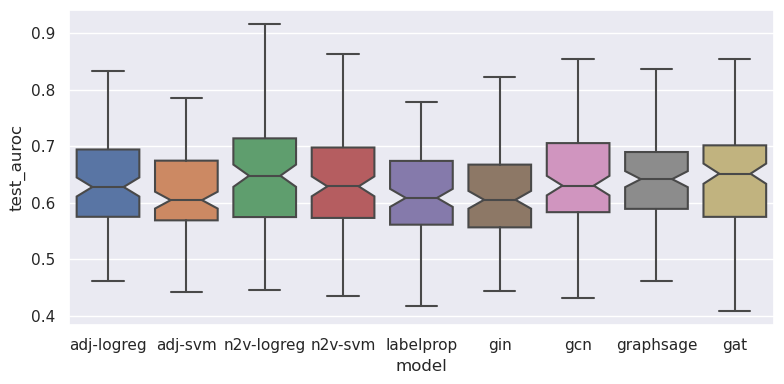

In [8]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=summary_df,
    x="model",
    y=metric,
    order=models,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

In [9]:
table = summary_df.pivot(index="task_name", columns="model", values=metric)
table

model,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop,n2v-logreg,n2v-svm
task_name,,,,,,,,,
DOID:0050117,0.780205,0.785740,0.739856,0.714284,0.704922,0.740277,0.677377,0.744416,0.731324
DOID:0050453,0.568450,0.581693,0.672577,0.704638,0.669907,0.702351,0.732901,0.748782,0.730497
DOID:0050567,0.653303,0.621918,0.701394,0.672675,0.697749,0.682226,0.596195,0.649241,0.649373
DOID:0050615,0.619391,0.614903,0.663646,0.615154,0.592114,0.565946,0.616580,0.695584,0.687902
DOID:0050621,0.644457,0.583061,0.656475,0.715893,0.650540,0.607341,0.498937,0.446174,0.462590
...,...,...,...,...,...,...,...,...,...
DOID:9834,0.694878,0.693489,0.679765,0.616362,0.646857,0.635936,0.574412,0.662962,0.672149
DOID:9835,0.703039,0.678053,0.664055,0.637093,0.621251,0.660309,0.660647,0.667462,0.666659
DOID:9840,0.649286,0.677380,0.684163,0.625650,0.676864,0.654261,0.540996,0.635695,0.616118


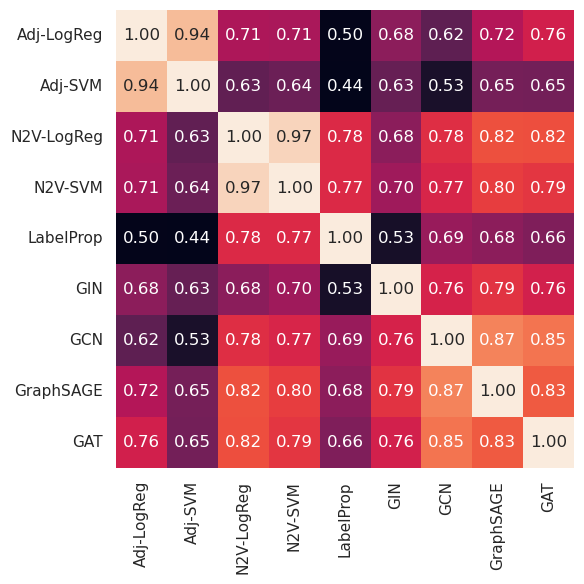

In [10]:
# Correlation of task-specific performance between models
plt.figure(figsize=(6, 6))
sns.heatmap(
    table[models].corr().rename(columns=model_name_dict, index=model_name_dict),
    annot=True,
    fmt=".2f",
    cbar=False,
    vmin=0.5,
)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
# plt.savefig("performance_correlations.png", dpi=300)
plt.show()

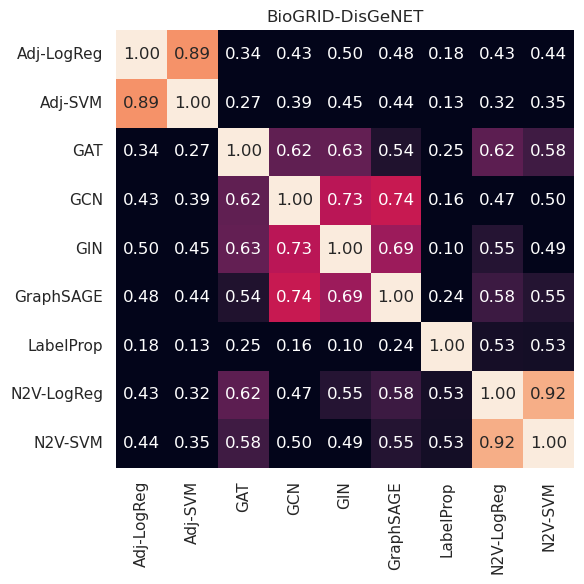

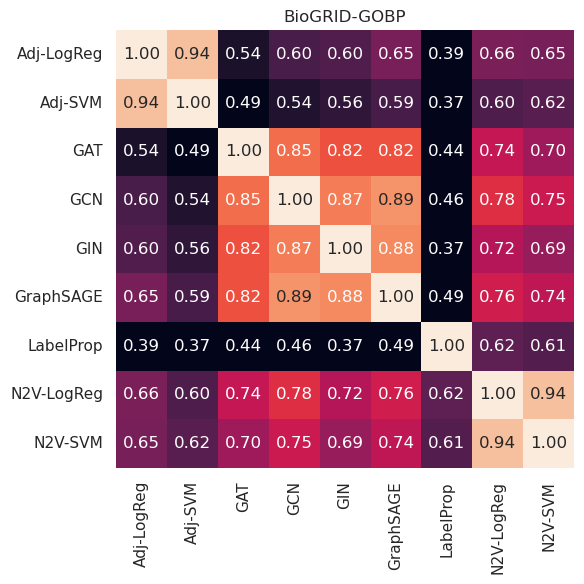

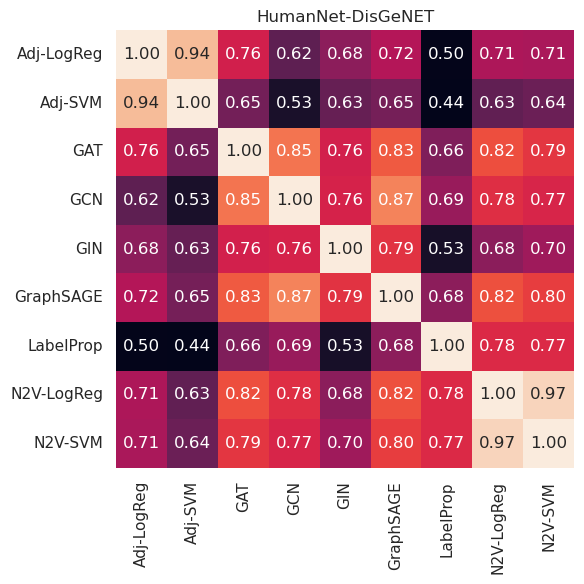

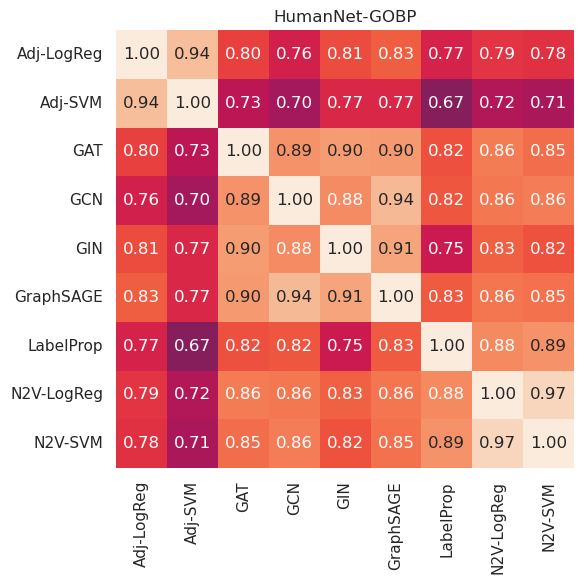

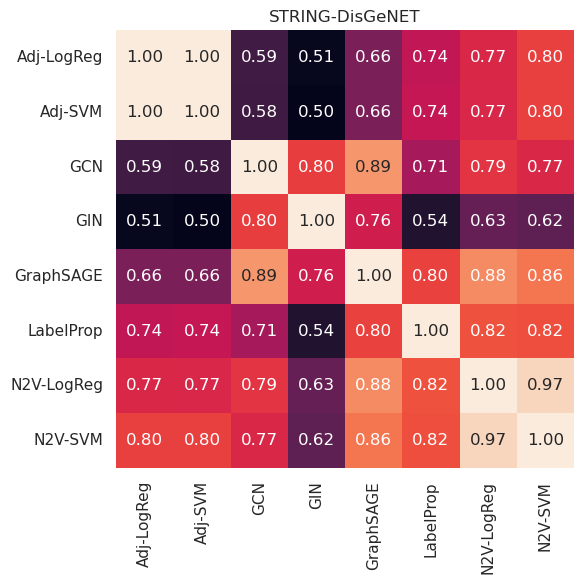

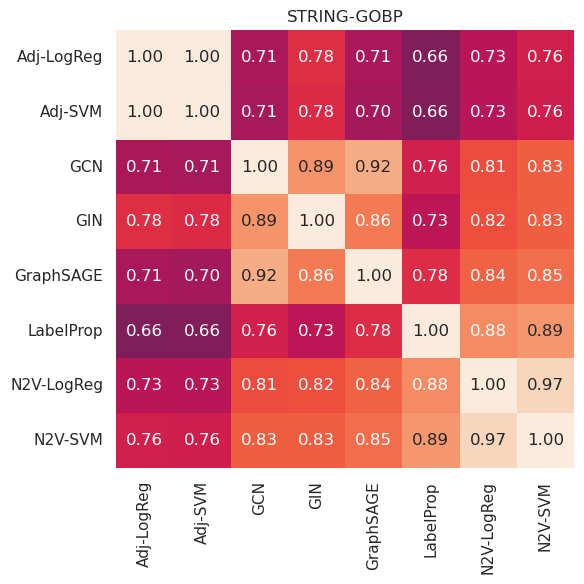

In [11]:
for network in networks:
    for label in labels:
        plt.figure(figsize=(6, 6))
        sns.heatmap(
            (
                df
                .groupby(
                    ["task_name", "network", "label", "model"],
                    as_index=False,
                )
                .mean()
                .query("network == @network & label == @label")
                .drop("runid", axis=1)
                .pivot(index="task_name", columns="model", values=metric)#[models]
                .corr()
                .rename(columns=model_name_dict, index=model_name_dict)
            ),
            annot=True,
            fmt=".2f",
            cbar=False,
            vmin=0.5,
        )
        plt.xlabel("")
        plt.ylabel("")
        plt.title(f"{network_name_dict[network]}-{label_name_dict[label]}")
        plt.tight_layout()
        plt.show()

## Given a model and the tasks of interest, which network to use

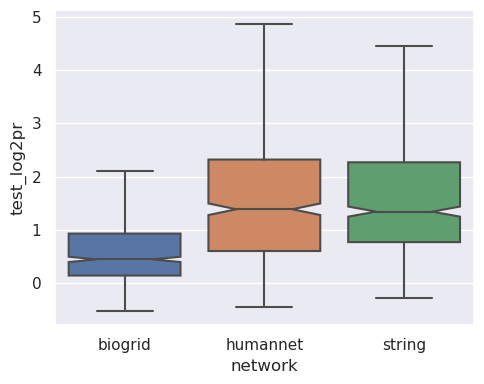

In [12]:
model = "gin"
label = "disgenet"
metric = "test_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

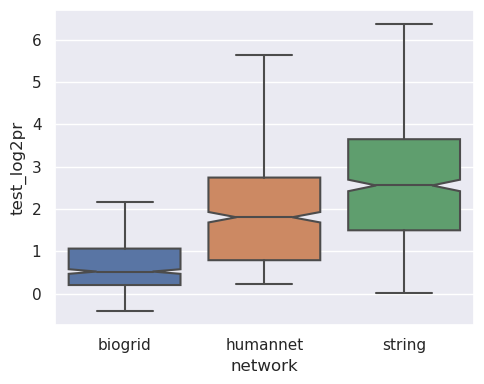

In [13]:
model = "adj-logreg"
label = "disgenet"
metric = "test_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

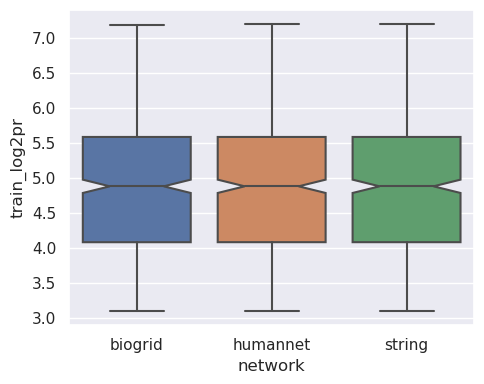

In [14]:
model = "adj-logreg"
label = "disgenet"
metric = "train_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

## No universally optimal model

In [15]:
network = "humannet"
label = "disgenet"
metric = "test_log2pr"

sub_df = df.query("network == @network & label == @label")

In [16]:
mdl1 = "adj-logreg"
mdl2 = "gat"

score_lst = []
for task, group_task in sub_df.groupby("task_name"):
    group_task_mdl = group_task.groupby("model")
    
    mdl1_scores = group_task_mdl.get_group(mdl1)[metric].values
    mdl2_scores = group_task_mdl.get_group(mdl2)[metric].values
    
    diff_score = mdl1_scores.mean() - mdl2_scores.mean()
    pval = scipy.stats.ttest_ind(mdl1_scores, mdl2_scores)[1]
    
    score_lst.append({
        "Task": task,
        f"{mdl1} mean": mdl1_scores.mean(),
        f"{mdl1} std": mdl1_scores.std(),
        f"{mdl2} mean": mdl2_scores.mean(),
        f"{mdl2} std": mdl2_scores.std(),
        "Mean difference": diff_score,
        "p-value": pval,
    })
    
pd.DataFrame(score_lst).sort_values("Mean difference")

,Task,adj-logreg mean,adj-logreg std,gat mean,gat std,Mean difference,p-value
35,DOID:11193,1.480925,0.000000e+00,3.927518,0.868742,-2.446593,4.913041e-04
112,DOID:9352,0.534417,0.000000e+00,2.783210,0.370409,-2.248793,1.959660e-06
72,DOID:2723,0.539181,0.000000e+00,2.692030,0.548032,-2.152848,4.972670e-05
64,DOID:1934,0.504471,0.000000e+00,2.649331,0.366689,-2.144859,2.601971e-06
43,DOID:12215,1.139275,0.000000e+00,3.055590,0.086027,-1.916315,7.112520e-11
...,...,...,...,...,...,...,...
6,DOID:0050735,3.913061,0.000000e+00,2.092355,0.244562,1.820706,4.080668e-07
114,DOID:9500,3.706410,0.000000e+00,1.752995,0.823903,1.953416,1.460455e-03
87,DOID:4079,3.229803,4.440892e-16,0.785506,0.296322,2.444298,1.838871e-07
45,DOID:1247,3.334007,0.000000e+00,0.871973,0.123656,2.462033,1.739770e-10
